In [669]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
from random import random
pd.set_option('display.max_columns', None)

df = pd.read_csv('train.csv')
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## Variable Description¶
* PassengerId : unique id number to each passenger
* Survived: passenger survived (1), died (0)
* Pclass: passenger class
* Name: passenger name
* Sex: gender of passenger
* Age: age of passenger
* SibSp: number of siblings and children
* Parch: number of parents and children
* Ticket: ticket number
* Fare: amount of money that spent on ticket
* Cabin: cabin number
* Embarked: oırt where passenger embarked (C = Cherbourg, Q = Queenstown, S = Couthampton)

In [670]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [671]:
# Feature engineering - apearance percentage & survival rate for each title
df['title'] = None
df.title = [name[name.find(',')+1:name.find('.')] for name in df.Name]
title_dict = df[['title','Survived']].groupby('title').count().sort_values(by='Survived')['Survived'].to_dict()
df['title_apr_perc'] = [title_dict[df.loc[i,'title']]/len(df) for i in df.index]
df['title_survival_rate'] = [len(df[(df.title==df.loc[i,'title'])&(df.Survived==1)])/len(df[df.title==df.loc[i,'title']]) for i in df.index]
df[['title','title_apr_perc','title_survival_rate']]

,title,title_apr_perc,title_survival_rate
0,Mr,0.580247,0.156673
1,Mrs,0.140292,0.792000
2,Miss,0.204265,0.697802
3,Mrs,0.140292,0.792000
4,Mr,0.580247,0.156673
...,...,...,...
886,Rev,0.006734,0.000000
887,Miss,0.204265,0.697802
888,Miss,0.204265,0.697802
889,Mr,0.580247,0.156673


In [672]:
df['Sex'] = [1 if item=='male' else 0 for item in df.Sex]
df['Age'] = df['Age'].fillna(np.mean(df['Age']))
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked')
df = pd.get_dummies(df, columns=['SibSp'], prefix='SibSp')
df = pd.get_dummies(df, columns=['Parch'], prefix='Parch')
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,title,title_apr_perc,title_survival_rate,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
886,887,0,2,"Montvila, Rev. Juozas",1,27.000000,211536,13.00,NaN,Rev,0.006734,0.000000,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.000000,112053,30.00,B42,Miss,0.204265,0.697802,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,W./C. 6607,23.45,NaN,Miss,0.204265,0.697802,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",1,26.000000,111369,30.00,C148,Mr,0.580247,0.156673,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
890,891,0,3,"Dooley, Mr. Patrick",1,32.000000,370376,7.75,NaN,Mr,0.580247,0.156673,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [673]:
y = ['Survived']
X = [col for col in df.columns if col not in ['PassengerId','Survived','Name','Ticket','Cabin','Parch','SibSp']]
X = ['title_survival_rate','Sex'] + [col for col in df.columns if 'Embarked_' in col] + [col for col in df.columns if 'SibSp_' in col]
TEST_AMOUNT = 0.3
EXCLUDE_OUTLIERS = True
print(f'X:{X}\ny:{y}\nTest set:{TEST_AMOUNT}\nTrain set:{1-TEST_AMOUNT}\nExclude Outliers:{EXCLUDE_OUTLIERS}')

X:['title_survival_rate', 'Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8']
y:['Survived']
Test set:0.3
Train set:0.7
Exclude Outliers:True


In [674]:
# test train classification
df['set'] = None
df['set'] = ['test' if random() < TEST_AMOUNT else 'train' for item in df.set]
df.set.value_counts()

train    647
test     244
Name: set, dtype: int64

In [675]:
# profile training data:
m = len(df[(df.set=='train')&(df.Sex==1)])
f = len(df[(df.set=='train')&(df.Sex==0)])
all_train = len(df[df.set=='train'])
print(f'Train:{all_train}; Male:{m}; Female:{f}')

Train:647; Male:419; Female:228


In [676]:
# mark outliers:
df['outlier'] = False
for col in ['Age','Fare']:
    mean = df[col].mean()
    std = df[col].std()
    df.loc[(df[col] < mean - 3*std)|(df[col] > mean + 3*std),'outlier'] = True

df.outlier.value_counts()

if EXCLUDE_OUTLIERS == True:
    df = df[df.outlier==False].reset_index(drop=True)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

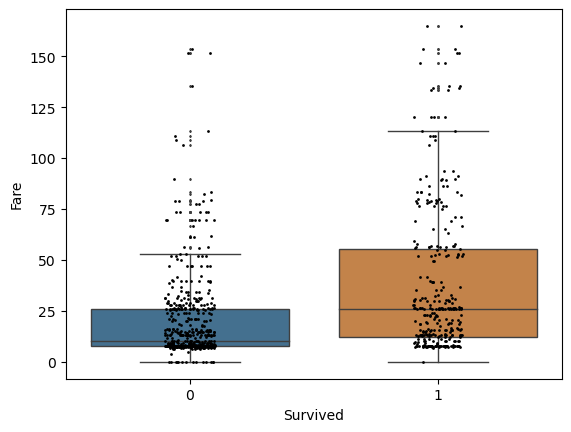

In [677]:
# Visualize features effect:
SELECTED_FEATURE = 'Fare'
sns.boxplot(x='Survived',y=SELECTED_FEATURE,data=df,saturation=0.5,linewidth=1,fliersize=1)
sns.stripplot(x='Survived',y=SELECTED_FEATURE,data=df,size=2,jitter=True,color='black')

<AxesSubplot:xlabel='Age', ylabel='Count'>

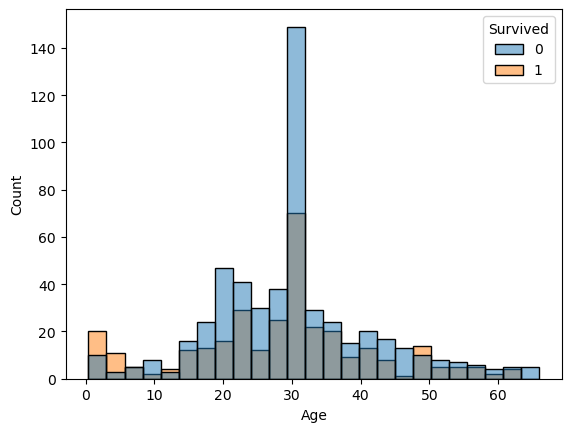

In [678]:
sns.histplot(data=df,x='Age',hue='Survived')

<AxesSubplot:xlabel='Sex', ylabel='count'>

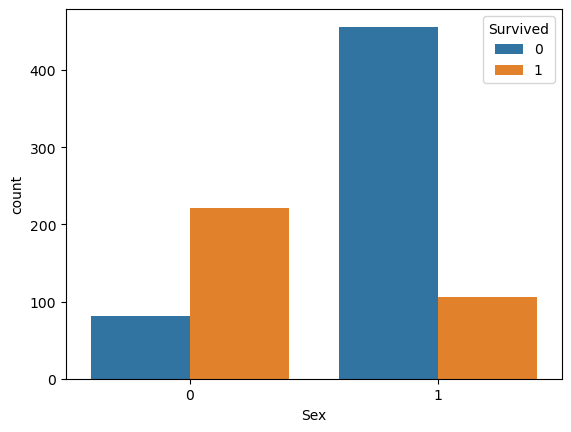

In [679]:
sns.countplot(x='Sex',hue='Survived',data=df)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

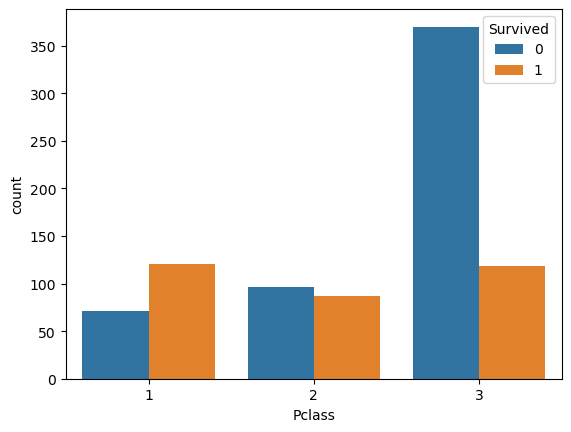

In [680]:
sns.countplot(x='Pclass',hue='Survived',data=df)

In [681]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,864.0,444.748843,257.517259,1.000000,221.750000,444.500000,664.250000,891.000000
Survived,864.0,0.378472,0.485287,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,864.0,2.343750,0.819028,1.000000,2.000000,3.000000,3.000000,3.000000
Sex,864.0,0.650463,0.477100,0.000000,0.000000,1.000000,1.000000,1.000000
Age,864.0,29.322935,12.490450,0.420000,22.000000,29.699118,35.000000,66.000000
Fare,864.0,26.500689,29.400192,0.000000,7.895800,13.860400,29.775000,164.866700
title_apr_perc,864.0,0.400729,0.216122,0.001122,0.204265,0.580247,0.580247,0.580247
title_survival_rate,864.0,0.383276,0.282146,0.000000,0.156673,0.156673,0.697802,1.000000
Embarked_C,864.0,0.178241,0.382937,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,864.0,0.087963,0.283405,0.000000,0.000000,0.000000,0.000000,1.000000


In [682]:
# Train logistic regression model
#log_reg = LogisticRegression(max_iter=1000,penalty='l2',solver='lbfgs',C=0.1)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X=df[X],y=df[y])
df['survival_prediction'] = log_reg.predict(df[X])
df['survival_prediction_probability'] = [max(prob) for prob in log_reg.predict_proba(df[X])]
df.head(3)

/homes/sagic/.conda/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,title,title_apr_perc,title_survival_rate,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,set,outlier,survival_prediction,survival_prediction_probability
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,NaN,Mr,0.580247,0.156673,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,test,False,0,0.828639
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C85,Mrs,0.140292,0.792000,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,train,False,1,0.883427
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,NaN,Miss,0.204265,0.697802,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,train,False,1,0.698547


In [556]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X=df[X],y=df[y])
df['survival_prediction'] = knn.predict(df[X])
df['survival_prediction_probability'] = [max(prob) for prob in knn.predict_proba(df[X])]
df.head(3)

/homes/sagic/.conda/envs/py3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,outlier,set,survival_prediction,survival_prediction_probability
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,False,train,0,0.8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C85,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,False,train,1,0.6
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,NaN,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,False,train,0,0.8


In [683]:
TRAIN_DATA = len(df[df.set=='train'])
CORRECT_TRAIN = len(df[(df.set=='train')&(df.Survived == df.survival_prediction)])
TEST_DATA = len(df[df.set=='test'])
CORRECT_TEST = len(df[(df.set=='test')&(df.Survived == df.survival_prediction)])

MALE_TRAIN_DATA = len(df[(df.set=='train')&(df.Sex==1)])
FEMALE_TRAIN_DATA = len(df[(df.set=='train')&(df.Sex==0)])
MALE_TRAIN_CORRECT_PREDICTIONS = len(df[(df.set=='train')&(df.Survived == df.survival_prediction)&(df.Sex==1)])
FEMALE_TRAIN_CORRECT_PREDICTIONS = len(df[(df.set=='train')&(df.Survived == df.survival_prediction)&(df.Sex==0)])

MALE_TEST_DATA = len(df[(df.set=='test')&(df.Sex==1)])
FEMALE_TEST_DATA = len(df[(df.set=='test')&(df.Sex==0)])
MALE_TEST_CORRECT_PREDICTIONS = len(df[(df.set=='test')&(df.Survived == df.survival_prediction)&(df.Sex==1)])
FEMALE_TEST_CORRECT_PREDICTIONS = len(df[(df.set=='test')&(df.Survived == df.survival_prediction)&(df.Sex==0)])

print(f'Overall Accuracy: Test={CORRECT_TRAIN/TRAIN_DATA}; Train={CORRECT_TEST/TEST_DATA}')
print(f'Male Accuracy: Test={MALE_TEST_CORRECT_PREDICTIONS/MALE_TEST_DATA}; Train={MALE_TRAIN_CORRECT_PREDICTIONS/MALE_TRAIN_DATA}')
print(f'Female Accuracy: Test={FEMALE_TEST_CORRECT_PREDICTIONS/FEMALE_TEST_DATA}; Train={FEMALE_TRAIN_CORRECT_PREDICTIONS/FEMALE_TRAIN_DATA}')

Overall Accuracy: Test=0.8048; Train=0.8493723849372385
Male Accuracy: Test=0.8831168831168831; Train=0.8308823529411765
Female Accuracy: Test=0.788235294117647; Train=0.7557603686635944
